In [1]:
from pyscipopt import Model, quicksum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from matplotlib.lines import Line2D
import yfinance as yf
import solve as sl
import data_handling as dh
from pathlib import Path
import pickle

pd.set_option('display.max_columns', None)

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

### 人的資本を考慮したシミュレーション型多期間ポートフォリオ最適化

従来の資産配分問題では、金融資産への投資のみをモデル化していた。

しかし、私たちが実際にお金の使い道を考えるとき、自分への投資（＝人的資本への投資）も考慮して資産配分を決定している。

本プロジェクトでは、人的資本を考慮した資産配分問題をモデル化することで、以下のような問いに回答を与えることを目的とする。

1. スキルや経験の違いによって、人的資本への投資比率はどのように変わるべきか？ 
2. 高齢者のリスキリングには意味があるのか？
3. スキルがない人は、人的資本には投資せず、稼いだお金を金融資産に投資をするべきか？


・外生変数

$T$ : 期間

$I$ : パス数（シミュレーション回数）

$\delta$ : 売買コスト

$r^{(i)}_t$ : $t$ 期のパス $i$ の無リスク金利

$\rho^{(i)}_{j,t}$ : $t$ 期のパス $i$ の危険資産 $j$ の価格

$W_0$ : 初期富

$W_E$ : 期待富（全パスの平均的な富がどの水準に達していたいか）

$W_G$ : 目標富（全パスが最低限どの水準に達していたいか）

$H_0$ : その人が時間によらず保持する人的資本ストック（単位：金額）

$\tau_1, ..., \tau_k, ... \tau_7$ : 8段階あるスキルの閾値（人的資本への投資額がどの値まで達すれば上の（下の）スキル段階になるか）

$w^{(i)}_1, ..., w^{(i)}_k, ..., w^{(i)}_8 $ : スキル段階に応じたリターン（金額）

$d_1, ..., d_m $ : $m$ 期前までの人的資本への投資に対する減衰係数

・内生変数

$v^{(i)}_{t}$ : $t$ 期の無リスク資産への投資額（金額）

$z_{jt}$ : $t$ 期の危険資産 $j$ の投資量（単元）

$q^{(i)}$ : 最終期でのパス $i$ の富の目標富に対する不足分

$h_t$ : 人的資本への投資額（金額、フロー）

$H_t$ : 人的資本のストック（金額）

$u_{t,k}$ : $t$ 期・パス $i$ のスキル段階を示す変数（ $H_t$ と閾値 $\tau_k$ の値に応じて、該当するスキル段階 $k$ で1, 他で0を取る変数）

$y^{(i)}_t$ : 人的資本から生み出される賃金（金額）

$$
\begin{align*}
  &\text{Minimize} \quad  \frac{1}{I} \sum_{i=1}^I q^{(i)} \\[5mm]
  &\text{subject to} \\
  &\quad \sum_{j=1}^n (1+\delta) \rho_{j0} z_{j0} + v_0 + h_0 \;=\; W_0 \\[5mm]
  &\quad \sum_{j=1}^n (1+\delta) \rho^{(i)}_{j1} z_{j1} + v^{(i)}_1 + h_1 \;=\; 
  \sum_{j=1}^n (1-\delta) \rho^{(i)}_{j1} z_{j0} + (1+r_0)v_0 + y^{(i)}_1 \\[5mm]
  &\quad \sum_{j=1}^n (1+\delta) \rho^{(i)}_{jt} z_{jt} + v^{(i)}_t + h_t \;=\; 
  \sum_{j=1}^n (1-\delta) \rho^{(i)}_{jt} z_{jt-1} + (1+r^{(i)}_{t-1})v^{(i)}_{t-1} + y^{(i)}_{t} \\[5mm]
  &\quad \sum_{j=1}^n (1-\delta) \bar{\rho}_{jT} z_{j,T-1} + \frac{1}{I} \sum_{i=1}^I \left\{ (1+r^{(i)}_{T-1})v^{(i)}_{T-1} + y^{(i)}_T \right\} \; \ge \; W_E \\[5mm]
  &\quad \sum_{j=1}^n (1-\delta) \rho^{(i)}_{jT} z_{j,T-1} + (1+r^{(i)}_{T-1})v^{(i)}_{T-1} + y^{(i)}_T  + q^{(i)}  \ge \; W_G\\[5mm]
  &\quad H_t = H_0 + d_1h_{t-1} + d_2h_{t-2} + ... + d_m h_{t-m}  \quad \text{（AR(m)モデルを意識）}\\[5mm]
  &\quad y^{(i)}_t = w^{(i)}_{s_1} u_{t,1} + w^{(i)}_{s_2} u_{t,2} + ... + w^{(i)}_{s_8} u_{t,8} \\[5mm]

  &\quad u_{t,s_k} \in \{0,1\} \\[5mm]
  &\quad \sum_{k=1}^{8} u_{t,k} = 1 \\[5mm]
  &\quad H_t < \tau_{1} + M(1-u_{t,1}) \quad k=1\\[5mm]
  &\quad \tau_{k-1} - M(1-u_{t,k-1}) \le H_t < \tau_{k} + M(1-u_{t,k}) \quad k=2,\dots,K-1\\[5mm]
  &\quad H_t \le \tau_{K-1} + M(1-u_{t,K-1}) \quad k=K \\[5mm]
  &\quad M \ge 0 \quad \text{十分大きな数} \\[5mm]
  &\quad z_{jt} \ge 0 \\[5mm]
  &\quad v_{t} \ge 0 \\[5mm]
  &\quad q^{(i)} \ge 0 \\[5mm]
  &\quad h_{t} \ge 0 \\[5mm]


\end{align*}
$$

<Axes: xlabel='time'>

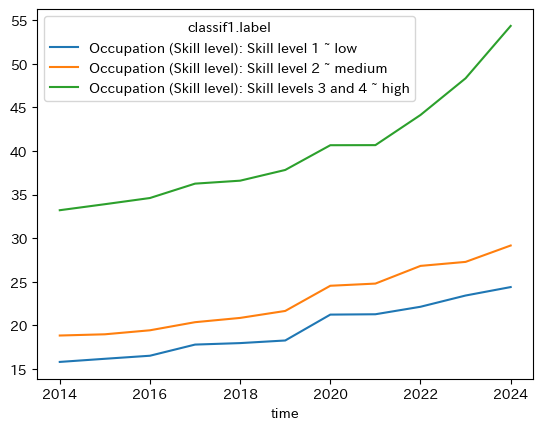

In [3]:
data = pd.read_csv(r"data/USA_A-filtered-2025-12-18.csv")
data[["classif1.label", "time", "obs_value"]].pivot_table(index="time", columns="classif1.label", values="obs_value").plot()

In [4]:
data.head()

,ref_area.label,source.label,indicator.label,sex.label,classif1.label,classif2.label,time,obs_value,obs_status.label,note_classif.label,note_indicator.label,note_source.label
0,United States of America,LFS - Current Population Survey,SDG indicator 8.5.1 - Average hourly earnings ...,Total,Occupation (Skill level): Skill levels 3 and 4...,NaN,2024,54.35,NaN,NaN,Currency: USA - United States dollar (USD),Repository: ILO-STATISTICS - Micro data proces...
1,United States of America,LFS - Current Population Survey,SDG indicator 8.5.1 - Average hourly earnings ...,Total,Occupation (Skill level): Skill level 2 ~ medium,NaN,2024,29.15,NaN,NaN,Currency: USA - United States dollar (USD),Repository: ILO-STATISTICS - Micro data proces...
2,United States of America,LFS - Current Population Survey,SDG indicator 8.5.1 - Average hourly earnings ...,Total,Occupation (Skill level): Skill level 1 ~ low,NaN,2024,24.38,NaN,NaN,Currency: USA - United States dollar (USD),Repository: ILO-STATISTICS - Micro data proces...
3,United States of America,LFS - Current Population Survey,SDG indicator 8.5.1 - Average hourly earnings ...,Total,Occupation (Skill level): Skill levels 3 and 4...,NaN,2023,48.34,NaN,NaN,Currency: USA - United States dollar (USD),Repository: ILO-STATISTICS - Micro data proces...
4,United States of America,LFS - Current Population Survey,SDG indicator 8.5.1 - Average hourly earnings ...,Total,Occupation (Skill level): Skill level 2 ~ medium,NaN,2023,27.27,NaN,NaN,Currency: USA - United States dollar (USD),Repository: ILO-STATISTICS - Micro data proces...


In [5]:

#######################################
param_type = "youth_noAI"

#外生変数
T=12; I=100

#取引コスト（変更可）
delta = 0.0 

initial_call_rate = 0.0001

#人的資本パラメータ（基本変更しない）
tau_skills = 7
K = tau_skills  + 1


#人的資本パラメータ（変更可）
#過去何年の人的資本投資までがストックに入るか
m = 2

W_0, W_E, W_G, H_0, dep_df = dh.set_params(m, T)



#スキルに応じた賃金
wage_n = np.array([150.0, 200.0, 300.0, 500.0, 700.0, 1000.0, 1500.0, 3000.0]) 
wage_ai = np.array([1500.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3000.0]) 
tax_n_comsumption=0.7
#wage_n = np.array([22_880, 31_000, 41_600, 49_920, 60_320]) * (1-tax_n_comsumption)
#wage_ai = np.array([60_320.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60_320]) * (1-tax_n_comsumption)


#スキルの閾値
#thresholds = np.array([200.0 * (t ** 1.001) for t in range(1,K)])
thresholds = np.array([200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0]) 

#外生ショックのパラメータ
p_H = 0.0
std_H = 30.0

transition_prob = 1.0
#AIのレジーム変化のパラメータ
transition_matrix = [[transition_prob, 1-transition_prob],
                     [0.01, 0.99]]

##########################################

shocks_H, shock_occurrence, shock_size = dh.simulate_random_shocks(T=T, p=p_H, mu=0.0, std=std_H)
w_std_df, r_df, rho_df = dh.get_simulated(T=T, I=I, rf_rate=initial_call_rate, seed=14)
asset_names = rho_df.columns.get_level_values("asset").unique().to_list()
wage_df = dh.simulate_wage(wage_n, wage_ai, w_std_df, transition_matrix, T)


data period: start=2014-09-01, end=2025-08-01
asset names: ['Wage', 'Corp. Bond', 'Stock', 'Crypto']


t,1,2,3,4,5,6,7,8,9,10,11,12
1,1.002803,1.020845,0.981734,1.035592,0.914368,1.062205,0.958207,1.025998,1.021658,0.995706,0.990218,0.981395
2,0.993168,1.022422,0.992797,0.989884,0.913709,1.036005,0.983065,1.062114,1.048889,0.989875,1.003003,0.983839
3,0.998377,1.010803,0.992859,0.979251,0.947405,1.037189,0.999327,1.020715,1.037419,0.961676,1.027821,0.986778
4,0.976732,0.997133,0.995670,0.983966,0.918628,1.038863,0.962843,0.942771,0.969399,0.995705,1.095295,1.004840
5,1.071563,0.989074,1.018469,0.992256,0.940590,0.991829,0.987839,1.003686,0.913901,0.991215,0.966983,0.993285
...,...,...,...,...,...,...,...,...,...,...,...,...
96,1.058916,1.012956,1.013173,1.099606,1.043810,1.029458,1.012727,0.927724,1.024183,1.041954,0.998869,1.031447
97,0.974064,1.003273,0.992767,0.964949,0.929344,0.921614,1.042615,1.007078,0.970497,1.007032,0.971471,1.030919
98,0.982804,1.007528,0.910007,1.008343,0.936710,1.002624,1.007804,1.081914,1.009774,1.030333,0.986750,1.027132
99,0.993727,1.005861,0.955657,0.943965,0.917683,1.056895,1.031993,0.977964,1.017672,1.009394,0.965609,1.056691


In [6]:
print(f"Param Type: {param_type}")
print(f"Period:{T} \n# of Simulations:{I}")
print(f"Initial Wealth:{W_0}", f"\nGuranteed Wealth:{W_G}", f"\nExpected Wealth:{W_E}")
print(f"Initial Human Cap: {H_0} \nTransition Prob:{transition_prob}")
print("Threholds")
display(thresholds)
print("Depreciation Matrix")
display(dep_df)
print("Wage Matrix")
display(wage_df.xs(1,level="path"))
display(wage_df)

Param Type: youth_noAI
Period:12 
# of Simulations:100
Initial Wealth:108.33333333333333 
Guranteed Wealth:10080.0 
Expected Wealth:14400.0
Initial Human Cap: 146.7799267622069 
Transition Prob:1.0
Threholds


array([200., 300., 400., 500., 600., 700., 800.])

Depreciation Matrix


,1,2,3,4,5,6,7,8,9,10,11,12
d_1,0.695315,0.646899,0.588792,0.544110,0.511741,0.487941,0.469943,0.455948,0.444796,0.435722,0.428204,0.421880
d_2,0.690661,0.597827,0.495251,0.422937,0.374113,0.340124,0.315495,0.296984,0.282634,0.271219,0.261940,0.254261


Wage Matrix


,1,2,3,4,5,6,7,8,9,10,11,12
wage level,,,,,,,,,,,,
wage1,151.002803,151.020845,150.981734,151.035592,150.914368,151.062205,150.958207,151.025998,151.021658,150.995706,150.990218,150.981395
wage2,201.002803,201.020845,200.981734,201.035592,200.914368,201.062205,200.958207,201.025998,201.021658,200.995706,200.990218,200.981395
wage3,301.002803,301.020845,300.981734,301.035592,300.914368,301.062205,300.958207,301.025998,301.021658,300.995706,300.990218,300.981395
wage4,501.002803,501.020845,500.981734,501.035592,500.914368,501.062205,500.958207,501.025998,501.021658,500.995706,500.990218,500.981395
wage5,701.002803,701.020845,700.981734,701.035592,700.914368,701.062205,700.958207,701.025998,701.021658,700.995706,700.990218,700.981395
wage6,1001.002803,1001.020845,1000.981734,1001.035592,1000.914368,1001.062205,1000.958207,1001.025998,1001.021658,1000.995706,1000.990218,1000.981395
wage7,1501.002803,1501.020845,1500.981734,1501.035592,1500.914368,1501.062205,1500.958207,1501.025998,1501.021658,1500.995706,1500.990218,1500.981395
wage8,3001.002803,3001.020845,3000.981734,3001.035592,3000.914368,3001.062205,3000.958207,3001.025998,3001.021658,3000.995706,3000.990218,3000.981395


1            2            3            4   \
path wage level                                                       
1    wage1        151.002803   151.020845   150.981734   151.035592   
     wage2        201.002803   201.020845   200.981734   201.035592   
     wage3        301.002803   301.020845   300.981734   301.035592   
     wage4        501.002803   501.020845   500.981734   501.035592   
     wage5        701.002803   701.020845   700.981734   701.035592   
...                      ...          ...          ...          ...   
100  wage4        501.009490   501.015608   501.010749   501.027231   
     wage5        701.009490   701.015608   701.010749   701.027231   
     wage6       1001.009490  1001.015608  1001.010749  1001.027231   
     wage7       1501.009490  1501.015608  1501.010749  1501.027231   
     wage8       3001.009490  3001.015608  3001.010749  3001.027231   

                          5            6            7            8   \
path wage level                                                       
1    wage1        150.914368   151.062205   150.958207   151.025998   
     wage2        200.914368   201.062205   200.958207   201.025998   
     wage3        300.914368   301.062205   300.958207   301.025998   
     wage4        500.914368   501.062205   500.958207   501.025998   
     wage5        700.914368   701.062205   700.958207   701.025998   
...                      ...          ...          ...          ...   
100  wage4        500.940826   501.037653   500.949038   501.040521   
     wage5        700.940826   701.037653   700.949038   701.040521   
     wage6       1000.940826  1001.037653  1000.949038  1001.040521   
     wage7       1500.940826  1501.037653  1500.949038  1501.040521   
     wage8       3000.940826  3001.037653  3000.949038  3001.040521   

                          9            10           11           12  
path wage level                                                      
1    wage1        151.021658   150.995706   150.990218   150.981395  
     wage2        201.021658   200.995706   200.990218   200.981395  
     wage3        301.021658   300.995706   300.990218   300.981395  
     wage4        501.021658   500.995706   500.990218   500.981395  
     wage5        701.021658   700.995706   700.990218   700.981395  
...                      ...          ...          ...          ...  
100  wage4        501.006503   501.026451   501.016202   500.975825  
     wage5        701.006503   701.026451   701.016202   700.975825  
     wage6       1001.006503  1001.026451  1001.016202  1000.975825  
     wage7       1501.006503  1501.026451  1501.016202  1500.975825  
     wage8       3001.006503  3001.026451  3001.016202  3000.975825  

[800 rows x 12 columns]

<Axes: >

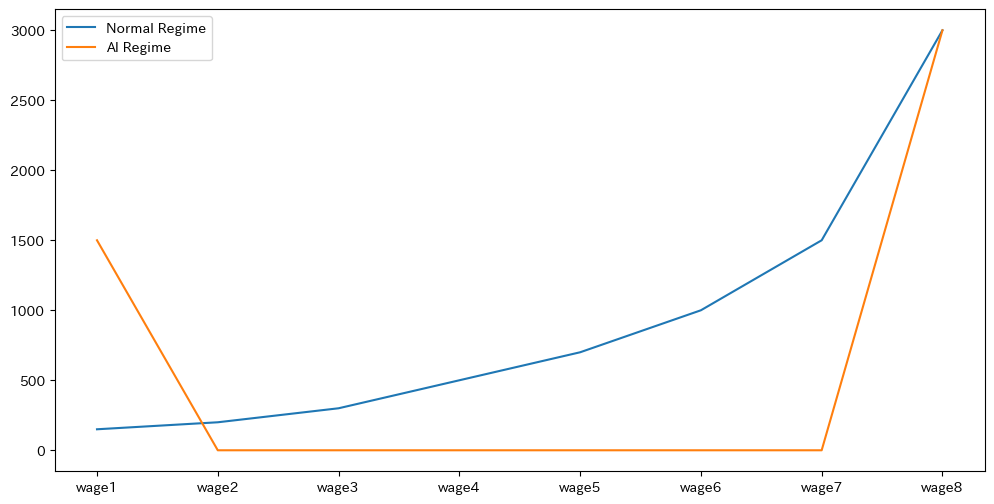

In [7]:
pd.DataFrame(np.vstack([wage_n, wage_ai]), columns=[f"wage{k}" for k in range(1,K+1)], index=["Normal Regime", "AI Regime"]).T.plot(figsize=(12,6))

労働供給者サイドと労働需要者サイドのショック

企業が意思決定して、労働需要者サイドの意思決定
企業にとっては別にどちらでもいい

労働供給者サイド、企業が意思決定によるリスク
怪我、結果が出ない→リスク

技術の進化→企業意思決定を変える→賃金テーブルのシフト（論文を参照）
ブルカラーの仕事がいきなりなくなる

βをwageにかえる（文字）
βを変える（時系列）

人的資本にもリスク
若い人が人的資本に投資しなくなる（含意）
ブルーカラー投資家

理論的な含意→みきさんの

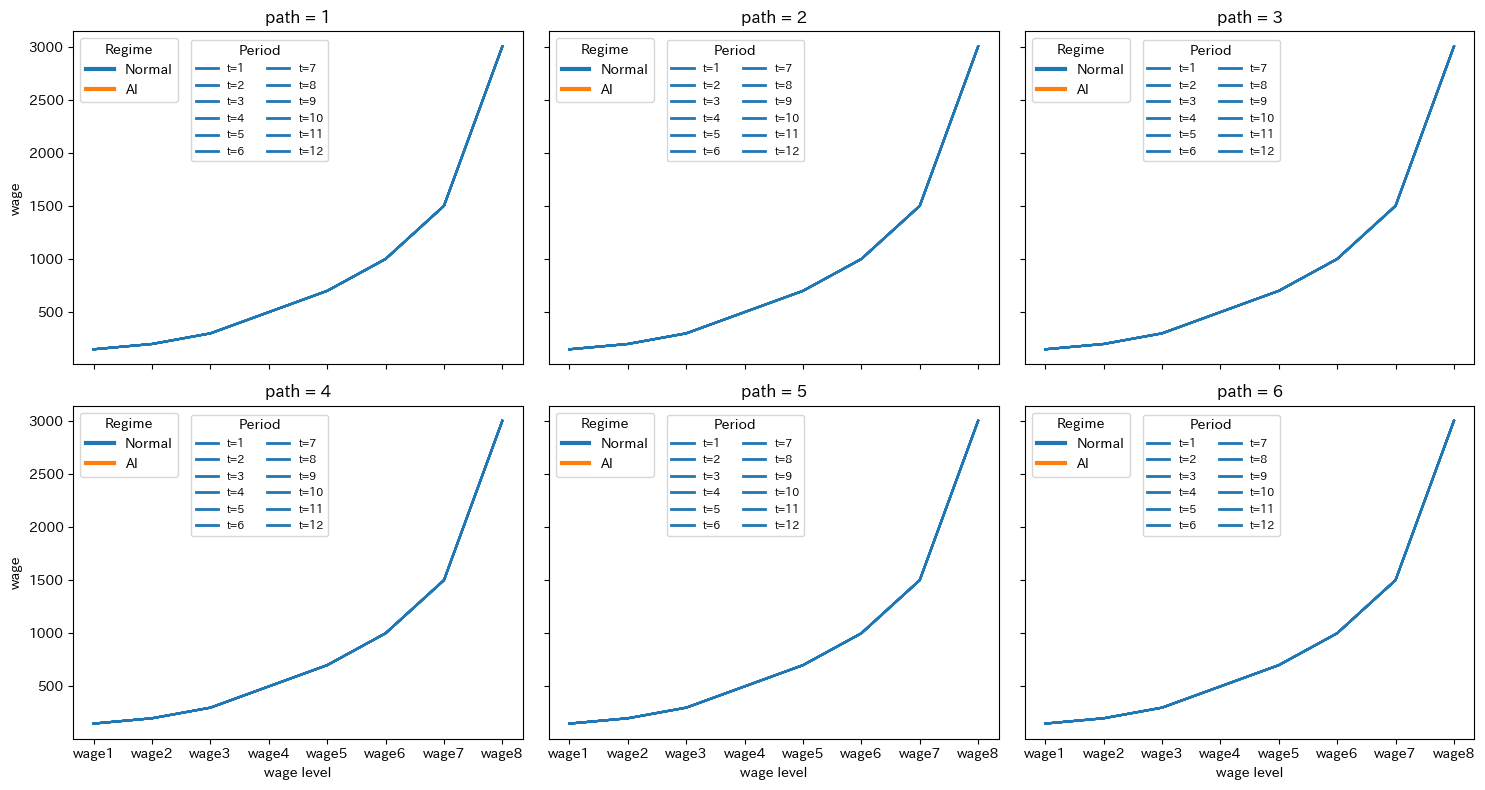

In [8]:
dh.visualize_wage(T,I,wage_df)

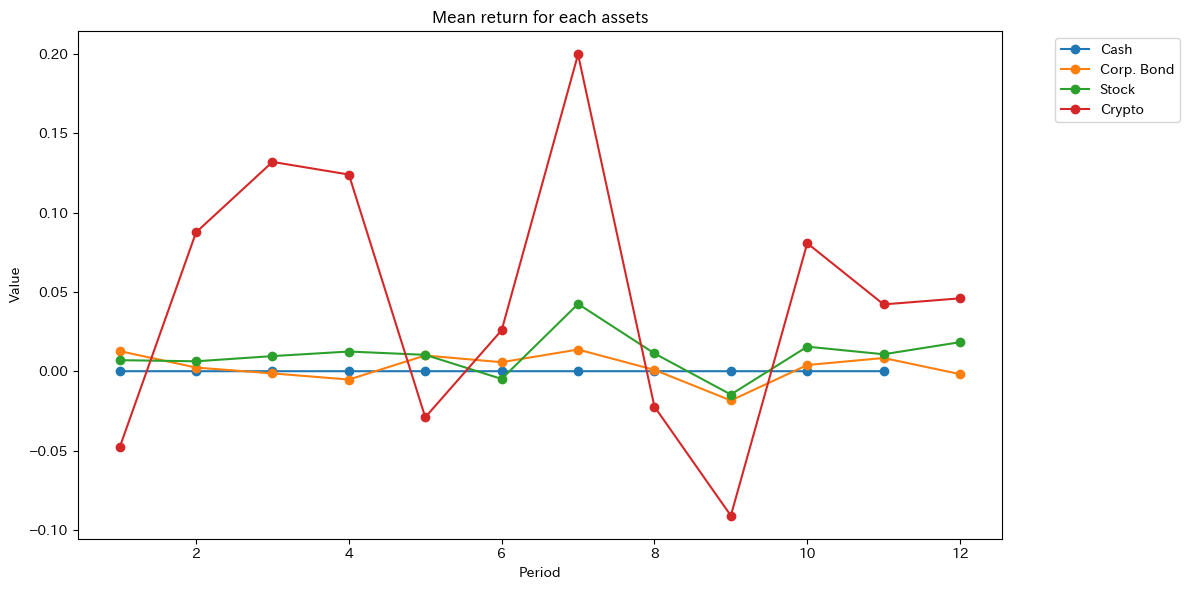

In [9]:
plt.figure(figsize=(12,6))

# unique asset list from the column MultiIndex
x_vals = np.array([t for t in range(1,T)])
y = r_df.drop(columns=0).mean(axis=0).to_numpy().ravel()
plt.plot(x_vals, y, marker="o", label="Cash")

for asset in asset_names:
    # Get a 1-D Series indexed by 期間
    y = rho_df.xs(asset, level="asset", axis=1)
    y = np.log(y).diff(axis=1).dropna(axis=1).mean(axis=0)
    # Ensure 1-D numpy array
    y_vals = y.to_numpy().ravel()
    x_vals = np.array([t for t in range(1,T+1)])
    plt.plot(x_vals, y_vals, marker="o", label=asset)

plt.title("Mean return for each assets")
plt.xlabel("Period")
plt.ylabel("Value")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

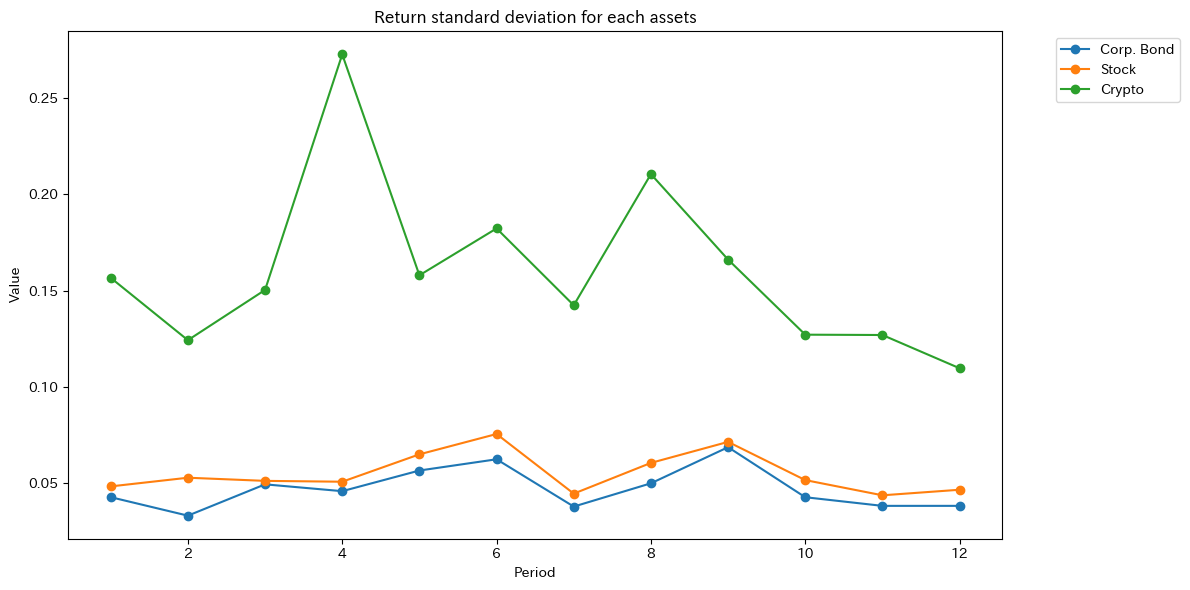

In [10]:
plt.figure(figsize=(12,6))

for asset in asset_names:
    # Get a 1-D Series indexed by 期間
    y = rho_df.xs(asset, level="asset", axis=1)
    y = np.log(y).diff(axis=1).dropna(axis=1).std(axis=0)
    # Ensure 1-D numpy array
    y_vals = y.to_numpy().ravel()
    x_vals = np.array([t for t in range(1,T+1)])
    plt.plot(x_vals, y_vals, marker="o", label=asset)

plt.title("Return standard deviation for each assets")
plt.xlabel("Period")
plt.ylabel("Value")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [11]:
H_min, H_max, M_t, Wt_max, Wt_5050, yt_max = sl.compute_bounds_and_M(I, T, H_0, W_0, dep_df, thresholds, shocks_H, asset_names, rho_df, wage_df, wage_n=wage_n)

Average Wage: Normal Regime


,1,2,3,4,5,6,7,8,9,10,11,12
wage1,150.0,150.0,150.0,150.0,150.0,150.0,150.0,150.0,150.0,150.0,150.0,150.0
wage2,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0
wage3,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0
wage4,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0
wage5,700.0,700.0,700.0,700.0,700.0,700.0,700.0,700.0,700.0,700.0,700.0,700.0
wage6,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
wage7,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
wage8,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0


In [12]:
Wt_max["H"]

{0: 108.33333333333333,
 1: np.float64(200.0),
 2: np.float64(300.0),
 3: np.float64(500.0),
 4: np.float64(1000.0),
 5: np.float64(3000.0),
 6: np.float64(3000.0),
 7: np.float64(3000.0),
 8: np.float64(3000.0),
 9: np.float64(3000.0),
 10: np.float64(3000.0),
 11: np.float64(3000.0),
 12: np.float64(3000.0)}

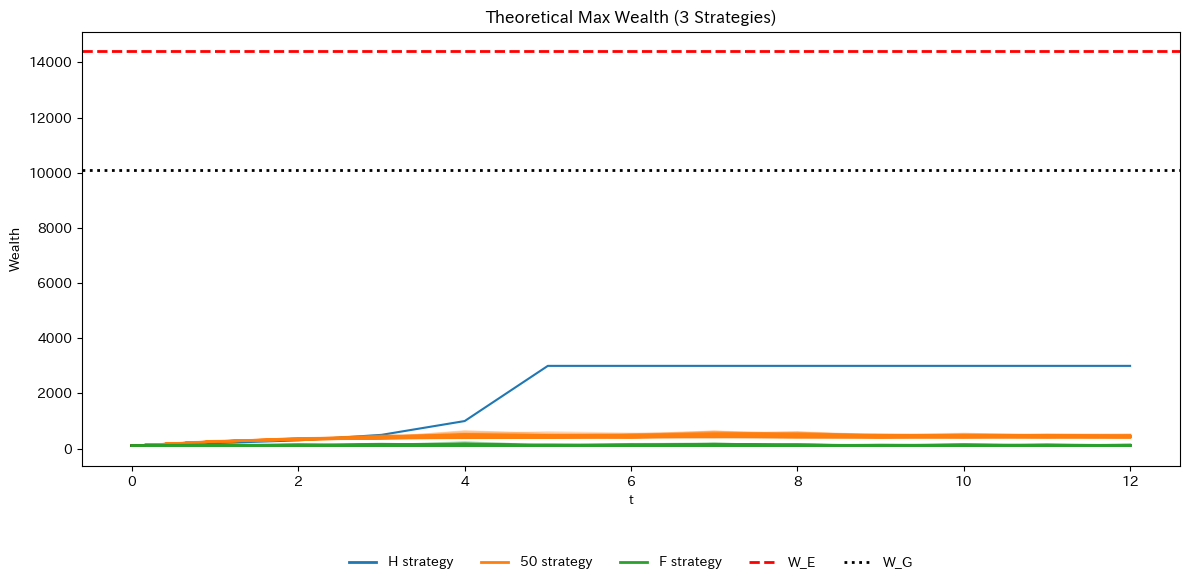

In [13]:
dh.visualize_Wt(I, W_E, W_G, Wt_max, T=T)

In [14]:
dict_params = {
    "Period": T,
    "#Sim": I,
    "Assets": asset_names,
    "#Skills" : K,
    "W_0" : W_0,
    "W_E" : W_E,
    "W_G" : W_G,
    "H_0" : H_0,
    "Thres": thresholds,
    "Wage": wage_df,
    "Dep": dep_df,
    "m": m,
    "Xi": transition_matrix
}

In [15]:
p = Path(f"results/{param_type}/params.pkl")
p.parent.mkdir(parents=True, exist_ok=True)

if not p.exists():
    with p.open("wb") as f:
        pickle.dump(dict_params, f)

In [16]:
mdl, vars = sl.build_scip_model(
    I,T,K,
    asset_names,
    delta,             # tx cost
    H0=H_0,
    thresholds=thresholds, 
    dep_df=dep_df, 
    m=m,      
    wage_df=wage_df,
    W0=W_0,
    WE=W_E,
    WG=W_G,                        # wealth params
    M_t=M_t,
    shock_H=shocks_H,                           # exogenous shocks to H per period (dict t->value)                                                           
    rho_df=rho_df,
    r_df=r_df,
    initial_call_rate=initial_call_rate,        
    h_cap=None,                         # cap on h per period    
    time_limit=None,
    feasibility=True,
    slack=True
)

variables added
initial budget constraint added
per-scenario budget constraints added
HC dynamics constraints added
one-hot regime selection constraints added
Big-M regime bracketing constraints added
wage mapping constraints added
expected terminal wealth constraint with slack added
pathwise terminal goal constraints with slack added
Modified objective with slack penalties


In [17]:
mdl.writeProblem("model.lp") 

wrote problem to file c:\Users\hmasa\JupyterProjects\GitHub\Human-Capital-as-an-Asset-for-Portfolio-Optimization\model.lp


In [18]:
sol = sl.solve_and_extract(mdl, vars, I, T, asset_names)

print("Average shortfall:", sol["obj"])

Status: optimal  #solutions: 2
s_exp = 0.0
scenario 1: s_path = 0.0
scenario 2: s_path = 0.0
scenario 3: s_path = 0.0
scenario 4: s_path = 0.0
scenario 5: s_path = 0.0
scenario 6: s_path = 0.0
scenario 7: s_path = 0.0
scenario 8: s_path = 0.0
scenario 9: s_path = 0.0
scenario 10: s_path = 0.0
scenario 11: s_path = 0.0
scenario 12: s_path = 0.0
scenario 13: s_path = 0.0
scenario 14: s_path = 0.0
scenario 15: s_path = 0.0
scenario 16: s_path = 0.0
scenario 17: s_path = 0.0
scenario 18: s_path = 0.0
scenario 19: s_path = 0.0
scenario 20: s_path = 0.0
scenario 21: s_path = 0.0
scenario 22: s_path = 0.0
scenario 23: s_path = 0.0
scenario 24: s_path = 0.0
scenario 25: s_path = 0.0
scenario 26: s_path = 0.0
scenario 27: s_path = 0.0
scenario 28: s_path = 0.0
scenario 29: s_path = 0.0
scenario 30: s_path = 0.0
scenario 31: s_path = 0.0
scenario 32: s_path = 0.0
scenario 33: s_path = 0.0
scenario 34: s_path = 0.0
scenario 35: s_path = 0.0
scenario 36: s_path = 0.0
scenario 37: s_path = 0.0
scen

In [19]:
# Extract z, Pplus, Pminus as DataFrames
z_val = sol["z"]
v_val = sol["v"]   # cash after trading at t
h_val = sol["h"]   # HC investment at t
H_val = sol["H"]   # HC stock at t
y_val = sol["y"]   # income at t

v0_val = sol["v0"]

Investment Weight: Senario Average (W_0:108.33333333333333, W_E:14400.0, W_G:10080.0)


,Cash,Human Cap,Corp. Bond,Stock,Crypto
t,,,,,
0,0.00,100.00,0.00,0.00,0.00
1,31.97,68.03,0.00,0.00,0.00
2,0.03,99.97,0.00,0.00,0.00
3,18.87,72.93,0.00,0.00,8.20
4,3.48,96.52,0.00,0.00,0.00
5,9.35,37.09,14.35,32.43,6.78
6,6.09,89.52,0.00,0.00,4.39
7,24.09,0.00,18.12,56.80,0.99
8,20.88,23.44,0.00,52.92,2.76


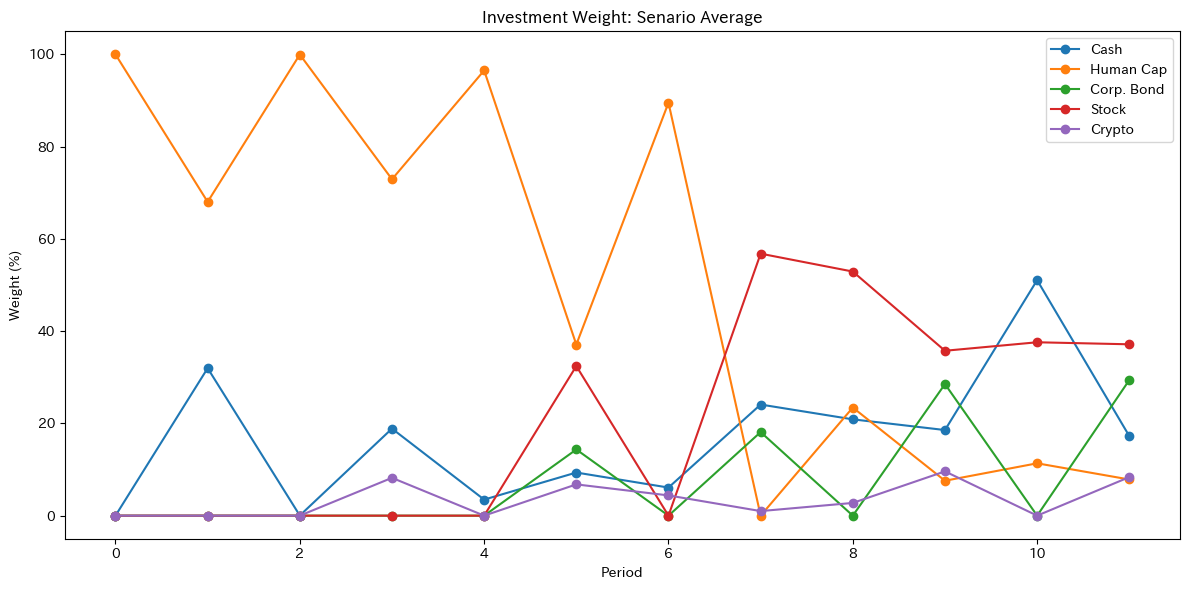

In [20]:
weights = sl.investment_ratio(rho_df, asset_names, sol, v0_val, v_val, h_val, z_val, I, T, W_0, W_E, W_G, param_type)

Asset Composition: Scenario Average (W_0:108.33333333333333, W_G:10080.0, W_E:14400.0)


,Wealth,Cash,Wage,Corp. Bond,Stock,Crypto
t,,,,,,
1,201.00,0.00,201.00,0.00,0.00,0.00
2,365.27,64.27,301.00,0.00,0.00,0.00
3,501.12,0.12,501.00,0.00,0.00,0.00
4,843.54,94.70,701.00,0.00,0.00,47.84
5,1530.57,29.58,1501.00,0.00,0.00,0.00
6,2471.14,146.39,1501.01,220.88,494.64,108.21
7,3287.25,151.48,3001.00,0.00,0.00,134.77
8,6312.93,813.32,3000.99,591.63,1874.32,32.67
9,7791.71,1355.58,3001.00,0.00,3273.75,161.37


<Axes: xlabel='t'>

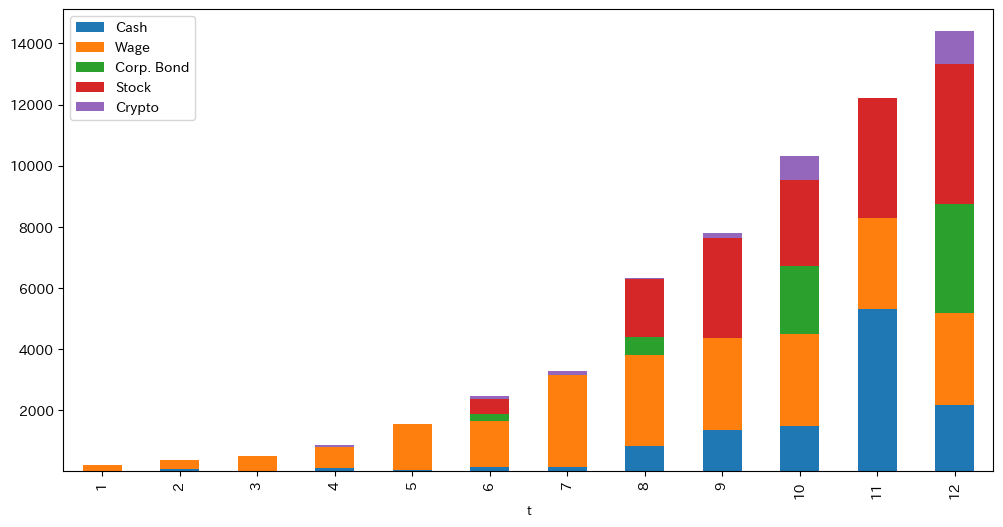

In [21]:
post_weights= sl.asset_composition(sol, rho_df, r_df, asset_names, v0_val, v_val, z_val, y_val, I, T, W_0, W_E, W_G, param_type)

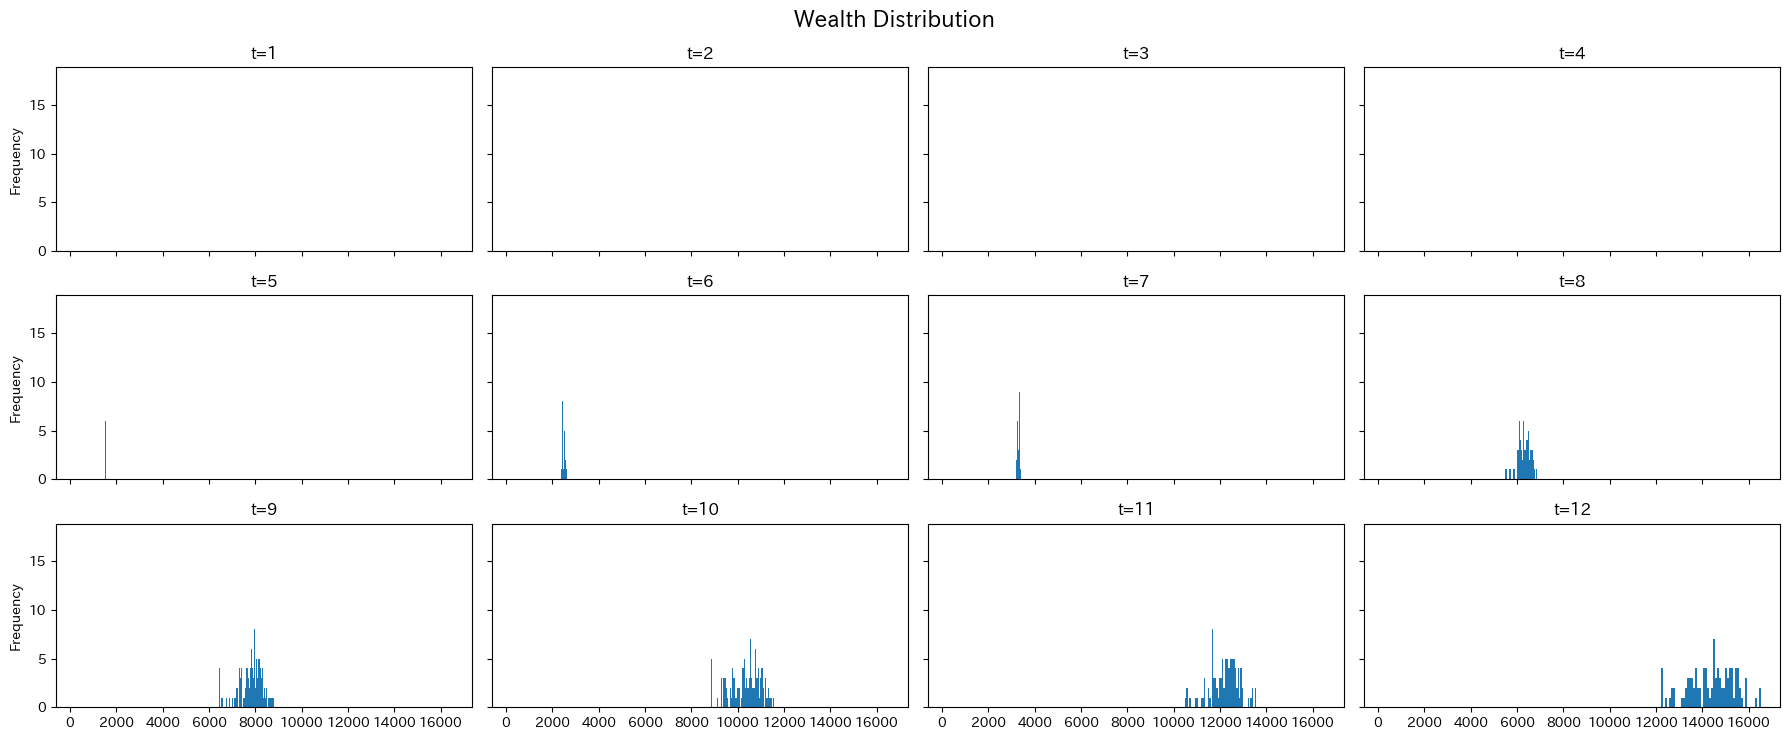

In [22]:
nrows=3; ncols=4
col=0; row=0
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex="all", sharey="all", figsize=(18,2.5*nrows))

for t in range(1,T+1):
    post_weights.xs(t, level="t")["Wealth"].plot.hist(ax=axes[row, col], bins=50, title=f"t={t}")
    col += 1
    if col == ncols:
        col = 0
        row+=1
fig.suptitle("Wealth Distribution", fontsize=16)
plt.tight_layout()
p = Path(f"results/{param_type}/wealth_dis.png")
if not p.exists():
    plt.savefig(f"results/{param_type}/wealth_dis.png")
plt.show()

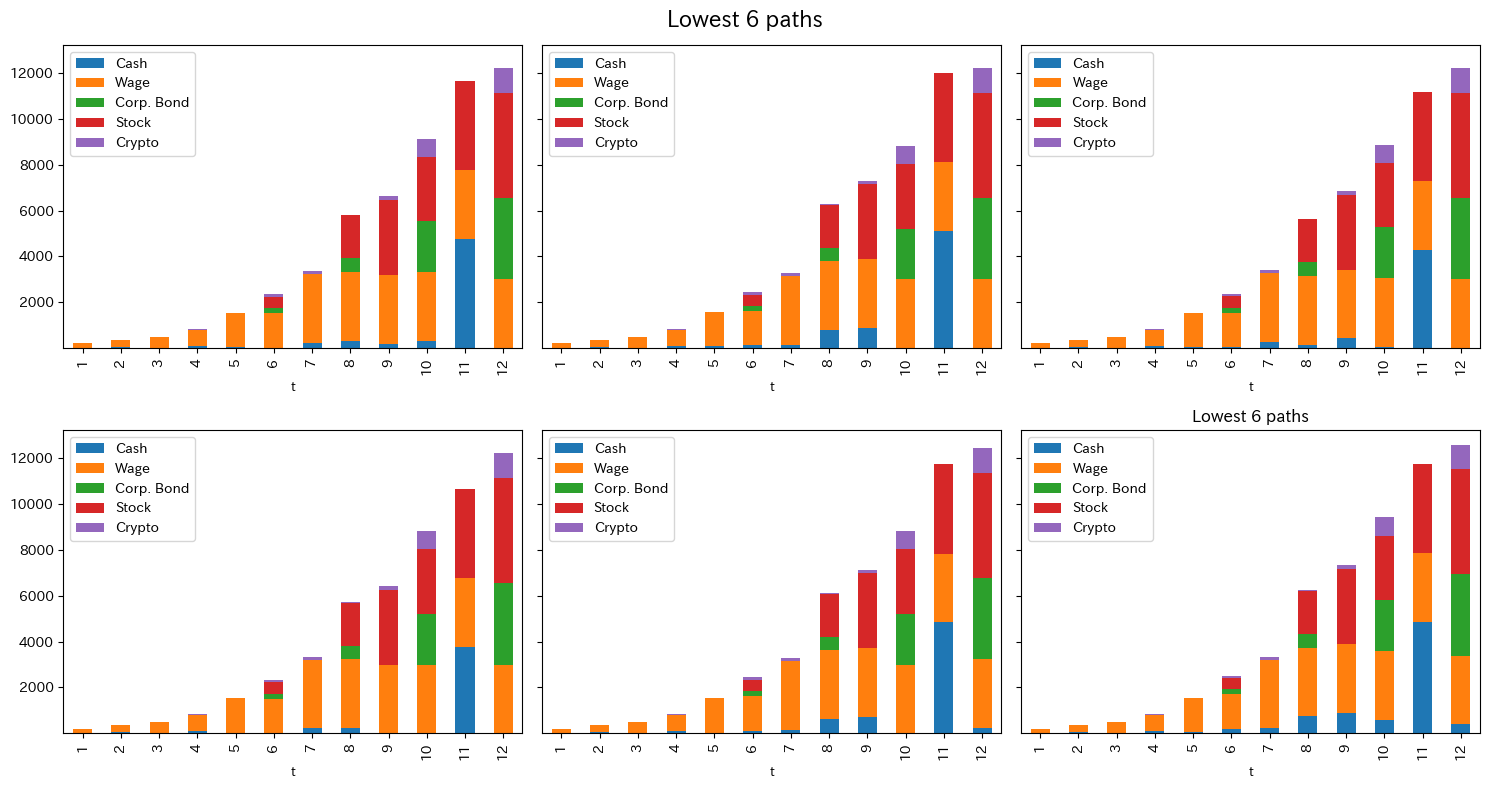

In [23]:
lo6_idx = post_weights.xs(T, level="t").sort_values(["Wealth"], ascending=True).head(6).index.to_list()
hi6_idx = post_weights.xs(T, level="t").sort_values(["Wealth"], ascending=False).head(6).index.to_list()

lo6_wealth_df = post_weights[post_weights.index.get_level_values("i").isin(lo6_idx)]
hi6_wealth_df = post_weights[post_weights.index.get_level_values("i").isin(hi6_idx)]

nrows=2 ; ncols=3
col=0 ; row=0
fig, axes = plt.subplots(nrows, ncols, sharey="all", figsize=(15,8))
plt.title("Lowest 6 paths")
for i in lo6_idx:
    lo6_wealth_df.xs(i, level="i").drop(columns=["Wealth"]).plot(ax=axes[row, col], kind="bar", stacked=True)
    col += 1
    if col == ncols:
        col = 0 
        row += 1

fig.suptitle("Lowest 6 paths", fontsize=16)
plt.tight_layout()
p = Path(f"results/{param_type}/lo5.png")
if not p.exists():
    plt.savefig(f"results/{param_type}/lo5.png")
plt.show()

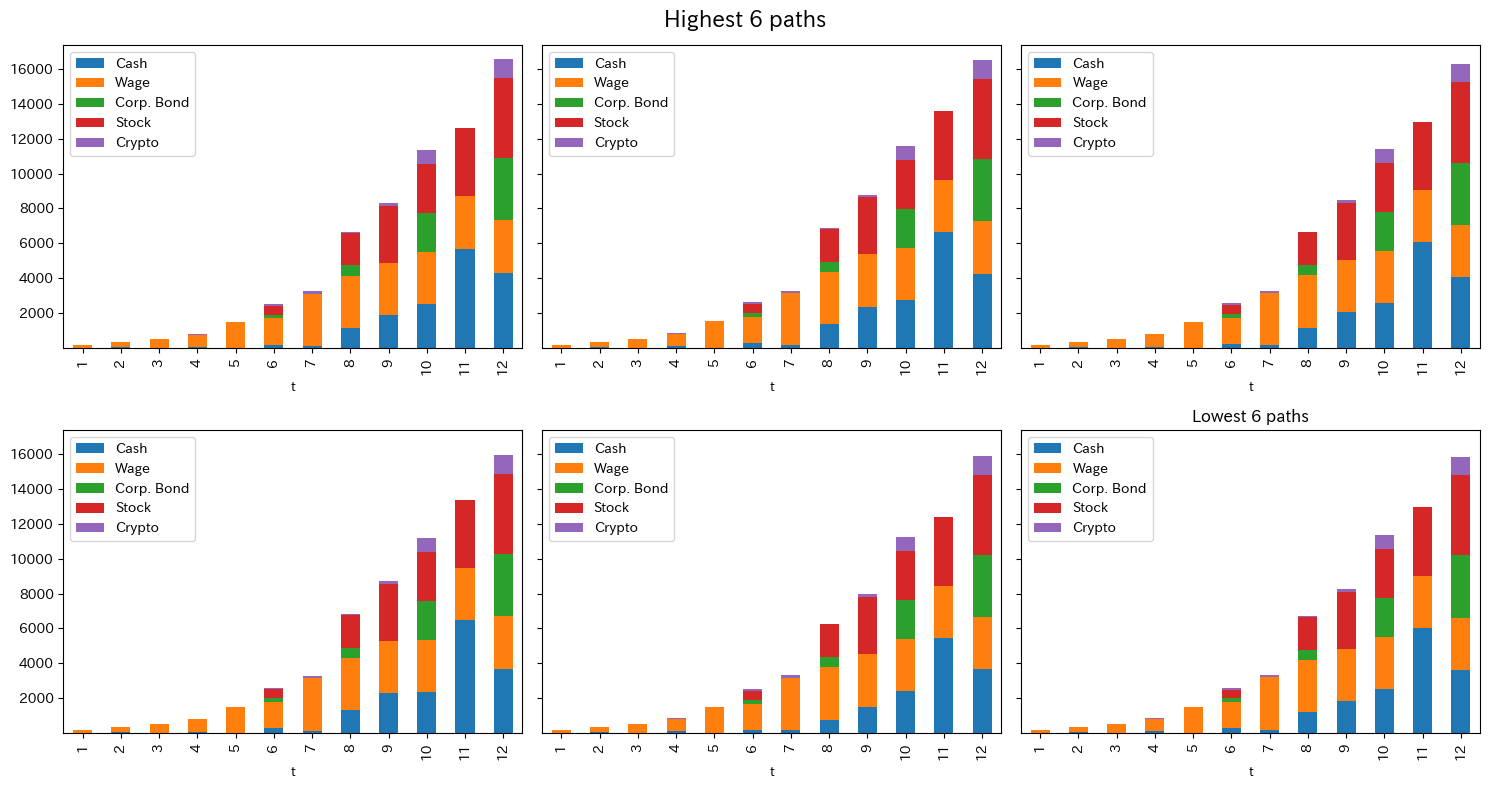

In [24]:
nrows=2 ; ncols=3
col=0 ; row=0
fig, axes = plt.subplots(nrows, ncols, sharey="all", figsize=(15,8))
plt.title("Lowest 6 paths")
for i in hi6_idx:
    hi6_wealth_df.xs(i, level="i").drop(columns=["Wealth"]).plot(ax=axes[row, col], kind="bar", stacked=True)
    col += 1
    if col == ncols:
        col = 0 
        row += 1

fig.suptitle("Highest 6 paths", fontsize=16)
plt.tight_layout()
p = Path(f"results/{param_type}/hi5.png")
if not p.exists():
    plt.savefig(f"results/{param_type}/hi5.png")
plt.show()

t,1,2,3,4,5,6,7,8,9,10,11,12
k=1,0,0,0,0,0,0,0,0,0,0,0,0
k=2,1,0,0,0,0,0,0,0,0,0,0,0
k=3,0,1,0,0,0,0,0,0,0,0,0,0
k=4,0,0,1,0,0,0,0,0,0,0,0,0
k=5,0,0,0,1,0,0,0,0,0,0,0,0
k=6,0,0,0,0,0,0,0,0,0,0,0,0
k=7,0,0,0,0,1,1,0,0,0,0,0,0
k=8,0,0,0,0,0,0,1,1,1,1,1,1


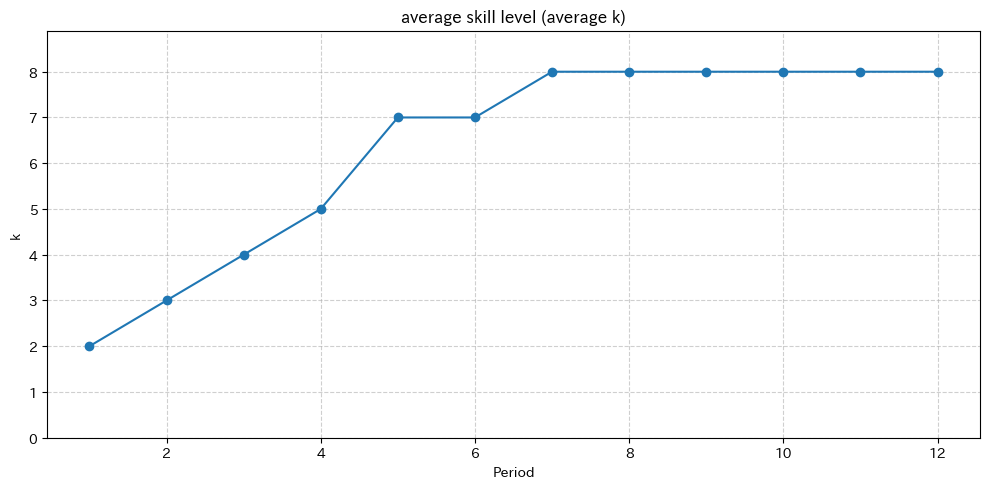

In [25]:
sl.show_skill_chg(sol, param_type)

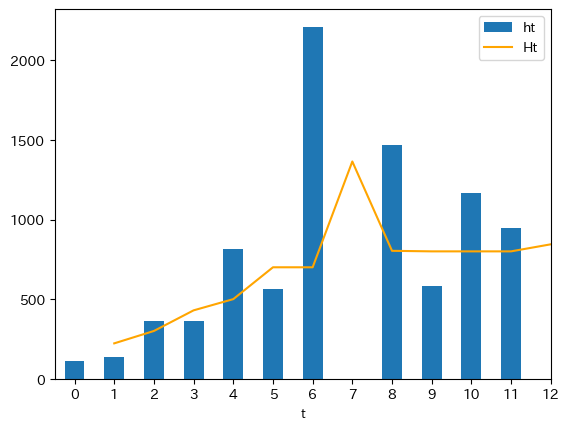

In [26]:
fig, ax = plt.subplots()
h_val.T.plot(ax=ax, kind="bar")
H_val.T.plot(ax=ax, color="orange")
ax.set_xticks(range(T+1))
ax.set_xticklabels(range(T+1))
plt.show()